--- Fetching Real-World Graphene Data (mp-48) ---


Retrieving ElectronicStructureDoc documents: 100%|█| 1/1 [00:00<00:00, 11335.96i


[SUCCESS] Band structure fetched.
Dirac Point identified at k = [-1.69619197  0.         -0.20666693]
Extracting linear dispersion data...
Dataset compiled: 245 points from Conduction Band.

--- Model Performance ---
linear     | MSE: 2.4650e-02 | R2: 0.7956
rbf        | MSE: 2.4739e-02 | R2: 0.7949
poly       | MSE: 8.3393e-02 | R2: 0.3087
sigmoid    | MSE: 2.2698e+05 | R2: -1881701.7141


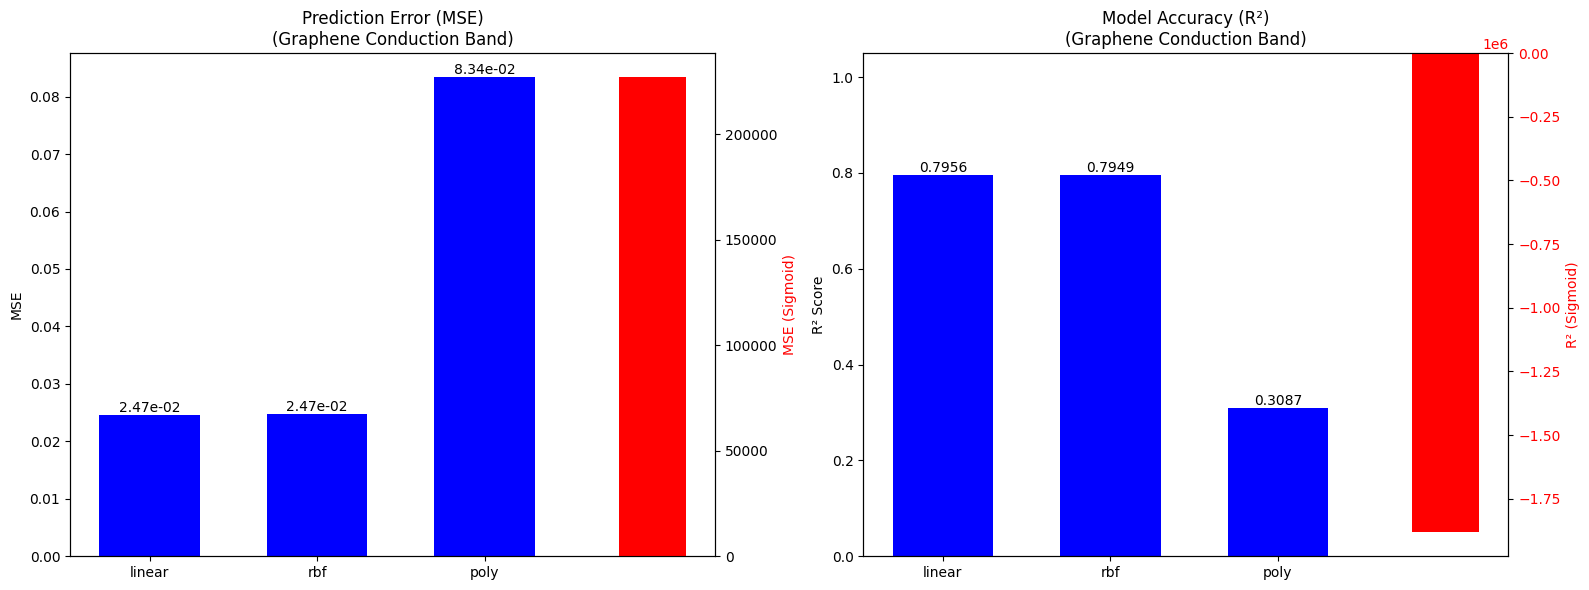

In [14]:
# -----------------------------------------------------------------------------
# Copyright (c) 2025 Renata Wong
#
# This code is supplementary material for the research paper:
# "Support Vector Machine Kernels as Quantum Propagators"
#
# Licensed under the MIT License.
# You may obtain a copy of the License at: https://opensource.org/licenses/MIT
# -----------------------------------------------------------------------------


import numpy as np
import matplotlib.pyplot as plt
from mp_api.client import MPRester
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from pymatgen.electronic_structure.core import Spin

# --- CONFIGURATION ---
# Replace with your actual API Key
MAPI_KEY = "YOUR-API-KEY"

print("--- Fetching Real-World Graphene Data (mp-48) ---")
try:
    with MPRester(MAPI_KEY) as mpr:
        # Fetch Band Structure
        bs = mpr.get_bandstructure_by_material_id("mp-48")
        print("[SUCCESS] Band structure fetched.")
        
        # Extract Data
        # We look at Spin.up (Graphene is non-magnetic)
        eigenvals = bs.bands[Spin.up]
        kpoints = np.array([k.cart_coords for k in bs.kpoints]) # (N, 3)
        e_fermi = bs.efermi
        
        # 1. FIND THE DIRAC POINT (K-POINT)
        # The Dirac point is where the band gap is zero (valence & conduction touch at Fermi level).
        # We search for the k-point where the energy is closest to E_fermi.
        min_diff = float('inf')
        k_dirac = None
        
        # Flatten all energies to find the global minimum distance to Fermi
        for band in eigenvals:
            dist = np.abs(band - e_fermi)
            min_idx = np.argmin(dist)
            if dist[min_idx] < min_diff:
                min_diff = dist[min_idx]
                k_dirac = kpoints[min_idx]

        print(f"Dirac Point identified at k = {k_dirac}")

        # 2. FEATURE ENGINEERING: MOMENTUM MAGNITUDE (q)
        # The Linear Kernel works if E is linear w.r.t input.
        # E ~ v_f * |k - K|. So we must use |k - K| as the feature.
        
        X_data = []
        y_data = []
        
        # Filter for the linear regime (Dirac Cone)
        # Window: +/- 1.0 eV around Fermi level
        print("Extracting linear dispersion data...")
        
        for band_idx, band_energies in enumerate(eigenvals):
            energies = band_energies - e_fermi
            
            # Check if band is relevant (crosses/touches Fermi)
            if np.min(energies) < 0.5 and np.max(energies) > -0.5:
                for i, E in enumerate(energies):
                    if abs(E) < 1.0: # Linear regime window
                        # Calculate q = |k - k_dirac|
                        # We use 2D norm (kx, ky) since Graphene is 2D
                        k_curr = kpoints[i]
                        q = np.linalg.norm(k_curr[:2] - k_dirac[:2])
                        
                        # We separate Valence (E<0) and Conduction (E>0) branches
                        # For simple regression, we can regress |E| vs q
                        # OR just regress the Conduction band (E > 0)
                        if E > 0: # Focus on Conduction band for cleanest linear fit
                            X_data.append([q]) 
                            y_data.append(E)

        X = np.array(X_data)
        y = np.array(y_data)
        
        print(f"Dataset compiled: {len(y)} points from Conduction Band.")

except Exception as e:
    print(f"[ERROR] {e}")
    print("Falling back to Synthetic Data...")
    # Synthetic Linear Data: E = 10 * q + noise
    X = np.random.uniform(0, 0.2, (200, 1))
    y = 10 * X.flatten() + np.random.normal(0, 0.05, 200)

# --- TRAINING ---
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale (StandardScaler helps SVR convergence)
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Train Kernels
kernels = ['linear', 'rbf', 'poly', 'sigmoid']
results = {}

print("\n--- Model Performance ---")
for k in kernels:
    if k == 'poly':
        # Degree 2 (Quadratic) to contrast with Linear
        # Graphene is Linear, so Degree 2 should be worse (overfitting curvature)
        model = SVR(kernel=k, degree=2, C=100) 
    else:
        model = SVR(kernel=k, C=100)
        
    model.fit(X_train_scaled, y_train) # y is small (eV), usually doesn't need scaling, but safe
    y_pred = model.predict(X_test_scaled)
    
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[k] = {'MSE': mse, 'R2': r2}
    
    print(f"{k.ljust(10)} | MSE: {mse:.4e} | R2: {r2:.4f}")

# --- PLOTTING ---
# Prepare Data
mse_vals = [results[k]['MSE'] for k in kernels if k != 'sigmoid']
r2_vals = [results[k]['R2'] for k in kernels if k != 'sigmoid']
mse_sig = results['sigmoid']['MSE']
r2_sig = results['sigmoid']['R2']

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
x = np.arange(len(kernels)) 

std_kernels = [k for k in kernels if k != 'sigmoid']

# Plot 1: MSE
bars1 = ax1.bar(np.arange(len(std_kernels)), mse_vals, color='blue', width=0.6)
ax1.set_ylabel('MSE')
ax1.set_title("Prediction Error (MSE)\n(Graphene Conduction Band)")
ax1.set_xticks(np.arange(len(std_kernels)))
ax1.set_xticklabels(std_kernels)
# Annotate
for bar in bars1:
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.2e}", 
             ha='center', va='bottom')

# Sigmoid MSE (Twin Axis)
ax1t = ax1.twinx()
bsig = ax1t.bar([len(std_kernels)], [mse_sig], color='red', label='Sigmoid', width=0.4)
ax1t.set_ylabel('MSE (Sigmoid)', color='red')
ax1t.tick_params(axis='y', labelcolor='black')

# Plot 2: R2
bars2 = ax2.bar(np.arange(len(std_kernels)), r2_vals, width=0.6, color='blue')
ax2.set_ylabel('R² Score')
ax2.set_title("Model Accuracy (R²)\n(Graphene Conduction Band)")
ax2.set_xticks(np.arange(len(std_kernels)))
ax2.set_xticklabels(std_kernels)
ax2.set_ylim(0, 1.05)
# Annotate
for bar in bars2:
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():.4f}", 
             ha='center', va='bottom')

# Sigmoid R2 (Twin Axis)
ax2t = ax2.twinx()
bsig2 = ax2t.bar([len(std_kernels)], [r2_sig], width=width, color='red')
ax2t.set_ylabel('R² (Sigmoid)', color='red')
ax2t.tick_params(axis='y', labelcolor='red')

plt.tight_layout()
plt.savefig("graphene_linear_proof.png")
plt.show()